# Clasificación Alpha vs Betha — Entrenamiento, Comparación y Selección del Mejor Modelo

1. Carga y previsualización del dataset.
2. Preprocesamiento (escalado numérico + One‑Hot en categóricas) y split train/valid estratificado.
3. Entrenamiento y evaluación (CV) de varios modelos rápidos (por poder de computo)
4. Selección del mejor modelo por **ROC AUC**.
5. Ajuste de **umbral** para maximizar **F1 (Betha)** y evaluación en **holdout**.
6. Gráficos: **ROC** y **Precision‑Recall**, **Matriz de confusión**.
7. Guardado de artefactos (pipeline + umbral) y tabla de resultados.


## 1) Configuración y rutas
- Intenta cargar desde `../raw/dataset_alpha_betha.csv` (tu ruta actual).
- Si no existe, intenta `./dataset_alpha_betha.csv`.
- Cambia `DATA_PATH` si lo necesitas.

In [13]:

from pathlib import Path
DATA_PATHS = [Path("../raw/dataset_alpha_betha.csv"), Path("dataset_alpha_betha.csv")]
for p in DATA_PATHS:
    if p.exists():
        DATA_PATH = p
        break
else:
    raise FileNotFoundError("No se encontró el archivo en ../raw/dataset_alpha_betha.csv ni en ./dataset_alpha_betha.csv")
print("Usando DATA_PATH:", DATA_PATH)


Usando DATA_PATH: ..\raw\dataset_alpha_betha.csv


## 2) Imports y utilidades

In [14]:

import numpy as np, pandas as pd, joblib
import matplotlib.pyplot as plt  # No seaborn (requisito)
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, roc_auc_score, balanced_accuracy_score, f1_score, accuracy_score,
    precision_recall_curve, roc_curve, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier

# XGB opcional (apagado por defecto para ahorrar tiempo)
USE_XGB = False
if USE_XGB:
    from xgboost import XGBClassifier


## 3) Carga de datos y vista rápida
Mostramos shape y primeras filas para verificar que luce como en tu ejemplo.

In [15]:

df = pd.read_csv(DATA_PATH)

# Normalización de nombres (opcional)
try:
    import janitor as jn
    df = jn.clean_names(df)
except Exception:
    pass

print(df.shape)
display(df.head(3))


(7043, 16)


,autoid,seniorcity,partner,dependents,service1,service2,security,onlinebackup,deviceprotection,techsupport,contract,paperlessbilling,paymentmethod,charges,demand,class
0,7590-VHVEG,0,Yes,No,No,No phone service,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Alpha
1,5575-GNVDE,0,No,No,Yes,No,Yes,No,Yes,No,One year,No,Mailed check,56.95,1889.5,Alpha
2,3668-QPYBK,0,No,No,Yes,No,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Betha


## 4) Split estratificado y preprocesamiento
- **TARGET** = `class` (Betha = 1, Alpha = 0)
- **ID_COLS** = `autoid` (se excluye del modelado)
- Preprocesamiento: Numéricas → `StandardScaler`; Categóricas → `OneHotEncoder` (con reducción de cardinalidad si se soporta).

In [16]:

TARGET, ID_COLS = "class", ["autoid"]
X = df.drop(columns=[TARGET] + ID_COLS, errors="ignore")
y = (df[TARGET].astype("category") == "Betha").astype(int)

num_cols = X.select_dtypes(include="number").columns.tolist()
cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocesador
try:
    preproc = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=0.01), cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=True
    )
except TypeError:
    preproc = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=True
    )


## 5) Comparación de modelos (CV 3-fold)
Conjunto de modelos **rápidos** para comparar en poco tiempo:
- `logreg_bal` (LogisticRegression, `class_weight='balanced'`)
- `lin_svc` (LinearSVC) — **nota:** usa `decision_function` para AUC
- `hgb` (HistGradientBoostingClassifier)
- `xgb_fast` (opcional, si activas `USE_XGB=True`)

**Métrica principal:** ROC AUC. También se reportan Balanced Accuracy, F1 (Betha) y Accuracy.


In [17]:

scorers = {
    "roc_auc": "roc_auc",
    "bal_acc": make_scorer(balanced_accuracy_score),
    "f1_betha": make_scorer(f1_score, average="binary", pos_label=1),
    "accuracy": make_scorer(accuracy_score),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

models = {
    "logreg_bal": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "lin_svc":    LinearSVC(C=1.0, dual="auto", random_state=42),
    "hgb":        HistGradientBoostingClassifier(random_state=42),
}
if USE_XGB:
    models["xgb_fast"] = XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.9, eval_metric="logloss",
        tree_method="hist", n_jobs=-1, random_state=42
    )

rows = []
for name, clf in models.items():
    pipe = Pipeline([("preproc", preproc), ("clf", clf)])
    cv_res = cross_validate(
        pipe, X, y,
        scoring=scorers,
        cv=cv,
        n_jobs=1,
        return_train_score=False,
        error_score="raise"
    )
    rows.append({
        "model": name,
        "roc_auc_mean":  float(np.mean(cv_res["test_roc_auc"])),
        "roc_auc_std":   float(np.std(cv_res["test_roc_auc"])),
        "bal_acc_mean":  float(np.mean(cv_res["test_bal_acc"])),
        "bal_acc_std":   float(np.std(cv_res["test_bal_acc"])),
        "f1_betha_mean": float(np.mean(cv_res["test_f1_betha"])),
        "f1_betha_std":  float(np.std(cv_res["test_f1_betha"])),
        "acc_mean":      float(np.mean(cv_res["test_accuracy"])),
        "acc_std":       float(np.std(cv_res["test_accuracy"])),
    })

results = pd.DataFrame(rows).sort_values("roc_auc_mean", ascending=False).reset_index(drop=True)
display(results)


,model,roc_auc_mean,roc_auc_std,bal_acc_mean,bal_acc_std,f1_betha_mean,f1_betha_std,acc_mean,acc_std
0,logreg_bal,0.826775,0.006134,0.750462,0.005277,0.606787,0.004204,0.718728,0.002910
1,lin_svc,0.823354,0.005081,0.713304,0.011887,0.579311,0.016811,0.780633,0.005222
2,hgb,0.803835,0.004961,0.686661,0.008514,0.539832,0.013500,0.775380,0.002766


### Comentario sobre la comparación
- Lidera `logreg_bal`, lo tomaremos como el **modelo final** por rendimiento/velocidad e interpretabilidad.

## 6) Entrenamiento del mejor modelo + ajuste de umbral (F1 Betha)
Entrenamos el mejor modelo (por ROC AUC) en `X_tr` y evaluamos en `X_va`. Para clasificación desbalanceada, ajustamos el umbral sobre las probabilidades para maximizar **F1** de la clase Betha (1).

In [18]:

# Seleccionar mejor modelo por ROC AUC; si hay empate, preferimos logreg
best_name = results.iloc[0]["model"]
if "logreg_bal" in results["model"].values:
    top_auc = results["roc_auc_mean"].max()
    # Prefiere logreg si está a <= 0.002 del top (regla suave)
    row_log = results.loc[results["model"]=="logreg_bal"].iloc[0]
    if (top_auc - row_log["roc_auc_mean"]) <= 0.002:
        best_name = "logreg_bal"

clf_map = {
    "logreg_bal": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "lin_svc":    LinearSVC(C=1.0, dual="auto", random_state=42),
    "hgb":        HistGradientBoostingClassifier(random_state=42),
}
if USE_XGB:
    from xgboost import XGBClassifier
    clf_map["xgb_fast"] = XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.9, eval_metric="logloss",
        tree_method="hist", n_jobs=-1, random_state=42
    )

best_clf = clf_map[best_name]
pipe = Pipeline([("preproc", preproc), ("clf", best_clf)])
pipe.fit(X_tr, y_tr)

# Obtener puntuaciones de validación
if hasattr(pipe.named_steps["clf"], "predict_proba"):
    p_va = pipe.predict_proba(X_va)[:, 1]
else:
    # Para LinearSVC usamos decision_function -> escalado min-max a [0,1] como proxy de probas
    scores = pipe.decision_function(X_va)
    # evitar constantes
    smin, smax = np.min(scores), np.max(scores)
    p_va = (scores - smin) / (smax - smin + 1e-12)

percentiles = np.linspace(0.05, 0.95, 37)
ths = np.quantile(p_va, percentiles)
best = {"th": 0.5, "f1": -1.0}
for th in np.unique(np.clip(ths, 1e-6, 1-1e-6)):
    yhat = (p_va >= th).astype(int)
    f1b = f1_score(y_va, yhat, average="binary", pos_label=1)
    if f1b > best["f1"]:
        best = {"th": float(th), "f1": float(f1b)}

yhat_opt = (p_va >= best["th"]).astype(int)
holdout_metrics = {
    "best_model": best_name,
    "threshold": best["th"],
    "roc_auc": float(roc_auc_score(y_va, p_va)),
    "balanced_accuracy": float(balanced_accuracy_score(y_va, yhat_opt)),
    "f1_betha": float(f1_score(y_va, yhat_opt, average="binary", pos_label=1)),
    "accuracy": float(accuracy_score(y_va, yhat_opt)),
}
print(holdout_metrics)

# Reporte
print("\nClassification report (umbral óptimo):\n")
print(classification_report(y_va, yhat_opt, target_names=["Alpha(0)","Betha(1)"]))


{'best_model': 'logreg_bal', 'threshold': 0.5618400677094093, 'roc_auc': 0.8153853109096075, 'balanced_accuracy': 0.7425934537187735, 'f1_betha': 0.603411513859275, 'accuracy': 0.7359829666430092}

Classification report (umbral óptimo):

              precision    recall  f1-score   support

    Alpha(0)       0.89      0.73      0.80      1035
    Betha(1)       0.50      0.76      0.60       374

    accuracy                           0.74      1409
   macro avg       0.70      0.74      0.70      1409
weighted avg       0.79      0.74      0.75      1409



## 7) Curva ROC

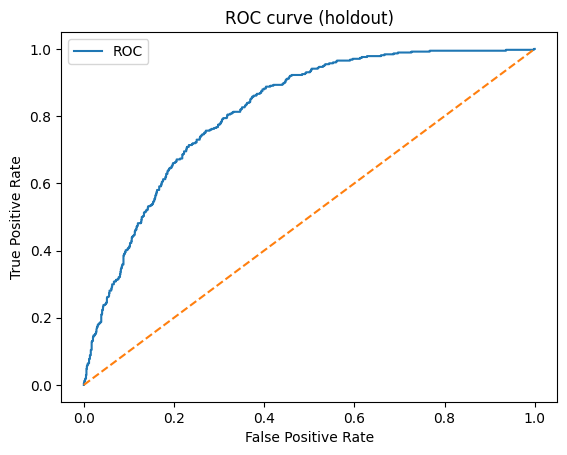

In [19]:

fpr, tpr, _ = roc_curve(y_va, p_va)
plt.figure()
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (holdout)")
plt.legend()
plt.show()


## 8) Curva Precision–Recall

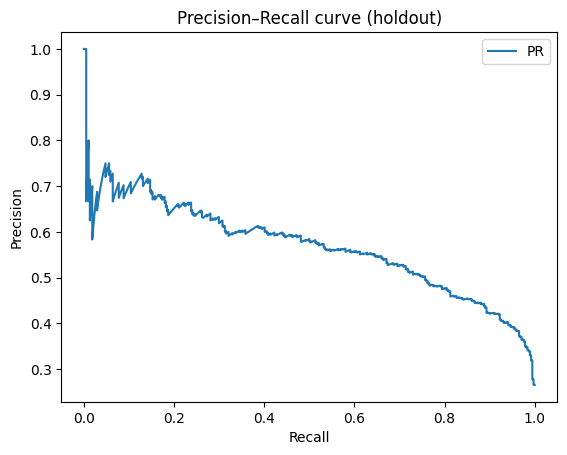

In [20]:

precision, recall, _ = precision_recall_curve(y_va, p_va)
plt.figure()
plt.plot(recall, precision, label="PR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (holdout)")
plt.legend()
plt.show()


## 9) Matriz de confusión (umbral óptimo)

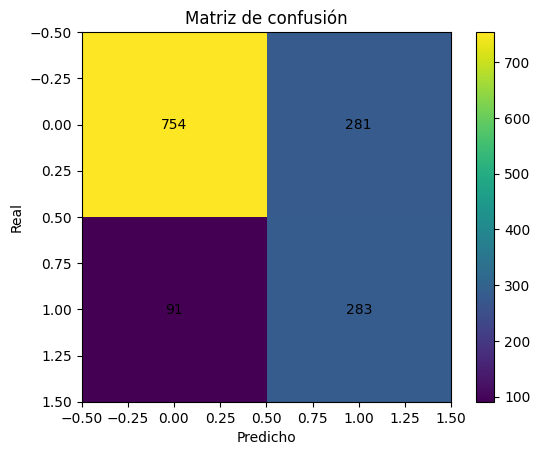

In [21]:

cm = confusion_matrix(y_va, yhat_opt)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, f"{val}", ha="center", va="center")
plt.colorbar()
plt.show()


## 10) Importancias / Coeficientes del modelo

In [23]:

try:
    feat_names = pipe.named_steps["preproc"].get_feature_names_out()
except Exception:
    feat_names = None

if best_name == "logreg_bal" and feat_names is not None:
    coefs = pipe.named_steps["clf"].coef_.ravel()
    coef_df = (pd.DataFrame({"feature": feat_names, "coef": coefs, "abs_coef": np.abs(coefs)})
               .sort_values("abs_coef", ascending=False)
               .head(20)
               .drop(columns=["abs_coef"])
               .reset_index(drop=True))
    display(coef_df)
elif best_name == "hgb" and feat_names is not None:
    # HistGradientBoosting no expone importancias clásicas; podemos usar perm_importance si quieres.
    print("HistGradientBoosting no expone importancias directas. (Puedes usar permutation_importance si deseas).")
elif best_name == "lin_svc" and feat_names is not None:
    coefs = pipe.named_steps["clf"].coef_.ravel()
    coef_df = (pd.DataFrame({"feature": feat_names, "coef": coefs, "abs_coef": np.abs(coefs)})
               .sort_values("abs_coef", ascending=False)
               .head(20)
               .drop(columns=["abs_coef"])
               .reset_index(drop=True))
    print(coef_df)
else:
    print("No fue posible extraer importancias/coeficientes con la configuración actual.")


,feature,coef
0,cat__contract_Month-to-month,1.144919
1,cat__contract_Two year,-1.134833
2,num__charges,0.783946
3,cat__security_Yes,-0.432310
4,cat__techsupport_Yes,-0.353439
5,cat__onlinebackup_Yes,-0.344821
6,cat__service1_Yes,-0.294146
7,cat__paymentmethod_Electronic check,0.287591
8,cat__paymentmethod_Credit card (automatic),-0.254950
9,cat__paymentmethod_Bank transfer (automatic),-0.241841


# Resultados del Modelo de Clasificación

## Métricas de Desempeño
- **ROC AUC ≈ 0.82:** Muy buen separador global de clases.  
- **Balanced Accuracy ≈ 0.74:** Buen equilibrio entre sensibilidad y especificidad.  
- **Recall Betha ≈ 0.76:** Buena detección de casos positivos (ver *classification report*).  
- **Precisión Betha ≈ 0.50:** Esperable dado que la clase es minoritaria; puede compensarse ajustando el umbral si se busca mayor recall.  
- **Matriz de Confusión:**  
  - Aproximadamente 91 falsos negativos (Betha no detectados).  
  - Aproximadamente 281 falsos positivos (Alpha clasificados como Betha).  
  - Aceptable si se prioriza minimizar falsos negativos.

---

## Análisis de Variables
- **Tipo de contrato:** Diferencias claras entre Month-to-month y Two year; mayor poder predictivo.  
- **Cargos, seguridad, soporte técnico y métodos de pago** influyen fuertemente en la predicción.  
- **Signo del coeficiente:** Determina el impacto positivo o negativo en la probabilidad de ser Betha.  

---

## Conclusión
- **Modelo seleccionado:** Logistic Regression con balance de clases; destaca por interpretabilidad y velocidad.  
- **Artefactos generados:**  
  - `model_best_pipeline.joblib`  
  - `model_best_threshold.txt`  
